# Problem Set 1 (40 points) -   Take-Home

You have been tasked to implement a predictor that will _rank_ documents according to their relevancy to a given query. 

You will use the [LETOR 4.0 dataset MQ2007]( https://arxiv.org/pdf/1306.2597.pdf) that has already been downloaded and is available in the `data` folder.

Each row is a query-document pair. The first column is the relevance label of this pair, the second column is query id, the following columns are features, and the end of the row is comment about the pair, including id of the document. The larger the relevance label, the more relevant the query-document pair. A query-document pair is represented by a 46-dimensional feature vector. 

## PS1.A (5 points) - Data Exploration

Create a pandas frame of the dataset and _print_ the first 5 rows in format where the first row will show the column names of the dataset. Instead of the feature names you can conveniently use the column index as a name.  

Is the 2nd column which is the query id a feature or not ?  Answer the question by coding the production of the $\mathbf x$ feature container and the $label y$ label container.  

In [2]:
# Insert the code here
import pandas

#Convert whatever the heck this is right to CSV
file_in = open("Querylevelnorm.txt", "r") 
file_out = open("Querylevelnorm.csv", "w")
column_names=["relevance", "qid"]
column_names.extend(str(i + 1) for i in range(46))
file_out.write(",".join(column_names))
file_out.write("\n")
for line in file_in:
    components = line.split(" ")
    components = components[:48]
    for i in range(47):
        components[i+1] = components[i+1].split(":")[1]
    file_out.write(",".join(components))
    file_out.write("\n")



In [3]:
from sklearn.model_selection import train_test_split 

#And now read it into the dataframes for train and test data
dataframe = pandas.read_csv("Querylevelnorm.csv")
train, test = train_test_split(dataframe, test_size=0.2)
X_test = test.drop(["relevance", "qid"], axis=1).iloc[:500]
y_test = test["relevance"].iloc[:500]
X_train = train.drop(["relevance", "qid"], axis=1).iloc[:5000]
y_train = train["relevance"].iloc[:5000]

print(X_train.head(5))
print(y_train.head(5))

              1         2     3    4         5    6    7    8    9   10  ...  \
45413  0.054054  0.000000  0.00  0.0  0.051282  0.0  0.0  0.0  0.0  0.0  ...   
2129   0.028571  0.000000  0.00  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
44080  0.082927  0.166667  0.25  0.0  0.087805  0.0  0.0  0.0  0.0  0.0  ...   
12684  0.026201  0.000000  0.00  0.0  0.026201  0.0  0.0  0.0  0.0  0.0  ...   
29479  0.121175  0.000000  1.00  0.0  0.122399  0.0  0.0  0.0  0.0  0.0  ...   

             37        38        39        40        41        42        43  \
45413  0.816962  0.680034  0.367979  0.531764  0.000000  0.000000  0.000000   
2129   0.378345  0.339693  0.472685  0.544893  0.000000  0.000000  0.000000   
44080  0.483955  0.465676  0.321132  0.669642  0.002986  0.045455  0.000000   
12684  0.861945  0.929353  0.806828  0.912207  0.003137  0.006289  0.033333   
29479  0.473112  0.966748  0.984075  0.939541  0.000000  0.000000  0.014085   

             44        45   46  
45413  0.71

## PS1.B (20 points)

Consult your textbook notebook `#4`` (the one that corresponds to Chapter 4) and express the problem of ranking as a regression problem. State the problem and implement the solution using the polynomial basis functions just like in [this notebook](https://pantelis.github.io/data-mining/aiml-common/lectures/regression/linear-regression/linear_regression.html). Solve the linear regression problem using SGD. Report the train and test MSE as a function of the epochs. 


This ranking problem can be turned into a regression problem by treating the ranking as a continuous variable. We can use linear regression by applying a polynomial basis function and then performing linear regression on the transformed dataset. In addition, we will also be normalizing the data such that the means of each input variable and the mean of the output variable are 0, and undoing the normalization when we make predictions. This way we do not have to worry about the intercepts at all during training. Our weights will therefore be represented as a vector, one for each independent variable. Our prediction using $m$ data points will therefore be

$\hat{y_i} = w_1x_{i1} + w_2x_{i2} + ... + w_mx_{im}$

And our error when predicting $n$ data points will be

$Err = \frac{1}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)^2$

Now we derive this with respect to a given weight, say, $w_j$.

$\frac{dErr}{dw_j} = \frac{d}{dw_j} \frac{1}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)^2$

$=\frac{1}{n}\sum_{i=1}^{n} \frac{d}{dw_j} (\hat{y_i}-y_i)^2$

$\frac{d}{dw_j} (\hat{y_i}-y_i)^2 = 2(\hat{y_i}-y_i)(\frac{d}{dw_j}(\hat{y_i}-y_i))$

$\frac{d}{dw_j}(\hat{y_i}-y_i) = \frac{d}{dw_j}\hat{y_i} = \frac{d}{dw_j}w_jx_{ij} = x_{ij}$

$\frac{dErr}{dw_j} = \frac{2}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)x_{ij}$

In the case where of stoachastic gradient descent, we have $n=1$

$\frac{dErr}{dw_j} = 2(\hat{y}-y)x_j$

We now have the mathematical TRUTH we need to implement SGD from scratch. Even in C if we so chose. We will first test the algorithm on a toy dataset, and then the actual data.

initializing
Training


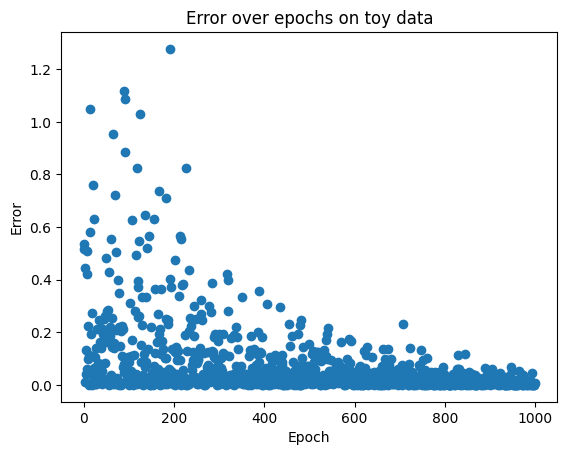

initializing
Training


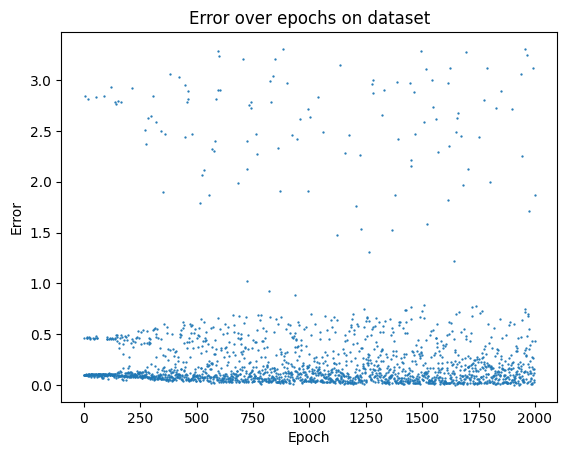

In [4]:
# Insert code here
from sklearn.preprocessing import PolynomialFeatures
import numpy
import random
from matplotlib import pyplot as plt

class Model:
    def __init__(self, X: list[list[float]], y: list[float]):
        assert len(X) > 0
        print("initializing")

        self.errors = [] # Will store the MSE as a function of epochs 
        self.coefficients = [0 for i in range(len(X[0]))]
        self.y_intercept = numpy.mean(y)
        x_t = numpy.transpose(X)
        self.x_intercepts = []
        for column in range(len(x_t)):
            self.x_intercepts.append(numpy.mean(x_t[column]))
        
        #Normalize the data
        self.X = X.copy()
        for row in range(len(self.X)):
            self.normalize(self.X[row])
        self.y = y.copy()
        for i in range(len(self.y)):
            self.y[i] -= self.y_intercept

    #Normalize inputs
    def normalize(self, x: list[float]):
        assert len(x) == len(self.coefficients)
        for i in range(len(x)):
                x[i] -= self.x_intercepts[i]

    #Predict the normalized y value given normalized x values
    def predict_normalized(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        return numpy.dot(self.coefficients, x)


    #Predict the y value given x values
    def predict(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        x_normalized = x.copy()
        self.normalize(x_normalized) #Normalize the input
        return self.predict_normalized(x_normalized) + self.y_intercept #De-normalize the output
    
    def fit(self, epochs: int, learning_rate: float):
        print("Training")
        self.errors = []
        for i in range(epochs):
            rand_index = random.randint(0, len(self.X)-1)
            x = self.X[rand_index]
            prediction = self.predict_normalized(x)
            error = (prediction - self.y[rand_index])**2
            self.errors.append(error)
            
            #Now to update the weights 
            for weight_index in range(len(self.coefficients)):
                gradient = 2*(prediction - self.y[rand_index])*x[weight_index]
                self.coefficients[weight_index] -= learning_rate * gradient

#To test the validity of our algorithm, we will test it on some toy data with 3 features
toy_data_x= []
toy_data_y = []
for i in range(10000):
    gen_w = random.random()
    gen_x = random.random()
    gen_z = random.random() + 10
    gen_y = gen_w + gen_x + gen_z + random.random() * 0.2 + 10
    toy_data_x.append([gen_w, gen_x, gen_z])
    toy_data_y.append(gen_y)

model = Model(toy_data_x, toy_data_y)
model.fit(1000, 0.01)
x_axis = [i for i in range(len(model.errors))]
plt.scatter(x_axis, model.errors)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Error over epochs on toy data")
plt.show()


#Now we will regress on the actual dataset using polynomial basis functions. HERE GOES!!!!
poly = PolynomialFeatures(3)
X_train_transformed = poly.fit_transform(X_train).tolist()
y_train_transformed = y_train.values.tolist()

model = Model(X_train_transformed, y_train_transformed)
model.fit(2000, 0.00005)
x_axis = [i for i in range(len(model.errors))]

plt.scatter(x_axis, model.errors, s=0.4)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Error over epochs on dataset")
plt.show()

So, we can see that the algorithm performed extremely well on the toy data (which is to be expected as the toy data was basically designed to be well-suited to multiple linear regression). On the actual data, it was still able to do something. We can see that towards the beginning at 0 epochs, the errors at each epoch seem to be condensed in three clusters, around error = 0, 0.5 and 2.7. As epochs went by, the cluster at 0.5 seems to have diffused and merged into the cluster at 0. This is probably indicating that the model is learning from the samples that were assigned a relevance ranking of 1. We will now quantitatively measure it's performance. Below I have calculated the MSE of the model on the test data, and compared it with the MSE produced by always choosing 0 as the prediction of the relevance, which should be what the predictor we have implemented does before training, computing the prediction as a dot product of the inputs and a vector of 0's.

In [5]:
# Now we will test its performance on test data.
from sklearn.metrics import mean_squared_error

X_test_transformed = poly.fit_transform(X_test)
y_pred = []
for i in range(len(X_test_transformed)):
    y_pred.append(model.predict(X_test_transformed[i]))

y_test_array = y_test.to_numpy()
print("Mean squared error of assuming the ranking is always 0 (untrained model): ", end="")
print(mean_squared_error(y_test_array, [0 for i in range(len(y_test_array))]))
print("Mean squared error of the trained model: ", end="")
print(mean_squared_error(y_test_array, y_pred))



Mean squared error of assuming the ranking is always 0 (untrained model): 0.49
Mean squared error of the trained model: 0.3685162417323933


## PS1.C (15 points)

Repeat the exercise of PS 1.B with the additional regualrization approach of  [this notebook](https://pantelis.github.io/data-mining/aiml-common/lectures/regression/linear-regression/linear_regression.html). Optimize $\lambda$ showing the train and test MSE as a function of this hyperparameter and for the optimal value of $\lambda$ plot the final train and test MSE as a function of the epochs.

So, when doing linear regression, it looks like we are now adding an extra term $\frac{\lambda}{2}||w||^2$. Our loss function for $m$ features is now

$Err = (\hat{y_i}-y_i)^2 + \frac{\lambda}{2}||w||^2$

$= (\hat{y_i}-y_i)^2 + \frac{\lambda}{2}\sqrt{w_1^2 + w_2^2 + ... + w_m^2}^2$

$= (\hat{y_i}-y_i)^2 + \frac{\lambda}{2}(w_1^2 + w_2^2 + ... + w_m^2)$

To calculate the derivative of this term with respect to a weight $w_j$, it looks like it's just going to be the power rule to give us

$\frac{dErr}{dw_j} = 2(\hat{y}-y)x_j + \lambda w_j$

Which gives us our new gradient.

I will optimize this hyperparameter using optuna.

[I 2023-10-21 22:37:47,439] A new study created in memory with name: no-name-0c0f2973-3d23-41dd-8877-20a278cef8d5


initializing
Training


[I 2023-10-21 22:39:01,689] Trial 0 finished with value: 0.36518199177123484 and parameters: {'special_hyperparameter': 5.000605939349223}. Best is trial 0 with value: 0.36518199177123484.


initializing
Training


[I 2023-10-21 22:40:12,447] Trial 1 finished with value: 0.36182033250192386 and parameters: {'special_hyperparameter': 9.871999210062775}. Best is trial 1 with value: 0.36182033250192386.


initializing
Training


[I 2023-10-21 22:41:27,076] Trial 2 finished with value: 0.3735969125036773 and parameters: {'special_hyperparameter': 9.188226860672094}. Best is trial 1 with value: 0.36182033250192386.


initializing
Training


[I 2023-10-21 22:42:41,045] Trial 3 finished with value: 0.37229611207547325 and parameters: {'special_hyperparameter': 9.47576780418459}. Best is trial 1 with value: 0.36182033250192386.


initializing
Training


[I 2023-10-21 22:43:52,046] Trial 4 finished with value: 0.36967329816158206 and parameters: {'special_hyperparameter': 7.113763276952061}. Best is trial 1 with value: 0.36182033250192386.


initializing
Training


[I 2023-10-21 22:45:04,991] Trial 5 finished with value: 0.3608665037831955 and parameters: {'special_hyperparameter': 5.450043359703881}. Best is trial 5 with value: 0.3608665037831955.


initializing
Training


[I 2023-10-21 22:46:16,761] Trial 6 finished with value: 0.3601688788268076 and parameters: {'special_hyperparameter': 1.669798044613301}. Best is trial 6 with value: 0.3601688788268076.


initializing
Training


[I 2023-10-21 22:47:38,537] Trial 7 finished with value: 0.36598571176999123 and parameters: {'special_hyperparameter': 7.598743610590118}. Best is trial 6 with value: 0.3601688788268076.


initializing
Training


[I 2023-10-21 22:48:55,302] Trial 8 finished with value: 0.3677079630885919 and parameters: {'special_hyperparameter': 8.748555979260415}. Best is trial 6 with value: 0.3601688788268076.


initializing
Training


[I 2023-10-21 22:50:10,381] Trial 9 finished with value: 0.3611922016095966 and parameters: {'special_hyperparameter': 1.1970712842580133}. Best is trial 6 with value: 0.3601688788268076.


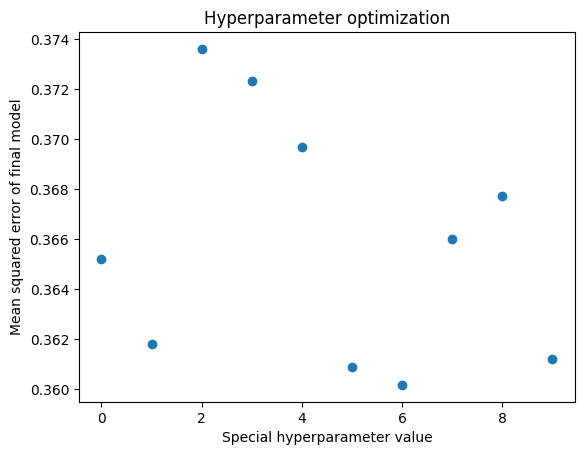

In [6]:
import optuna

class Model_2:
    def __init__(self, X: list[list[float]], y: list[float], special_hyperparameter: float):
        assert len(X) > 0
        print("initializing")
        self.special_hyperparameter = special_hyperparameter
        self.errors = [] # Will store the MSE as a function of epochs 
        self.coefficients = [0 for i in range(len(X[0]))]
        self.y_intercept = numpy.mean(y)
        x_t = numpy.transpose(X)
        self.x_intercepts = []
        for column in range(len(x_t)):
            self.x_intercepts.append(numpy.mean(x_t[column]))
        
        #Normalize the data
        self.X = X.copy()
        for row in range(len(self.X)):
            self.normalize(self.X[row])
        self.y = y.copy()
        for i in range(len(self.y)):
            self.y[i] -= self.y_intercept

    #Normalize inputs
    def normalize(self, x: list[float]):
        assert len(x) == len(self.coefficients)
        for i in range(len(x)):
                x[i] -= self.x_intercepts[i]

    #Predict the normalized y value given normalized x values
    def predict_normalized(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        return numpy.dot(self.coefficients, x)


    #Predict the y value given x values
    def predict(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        x_normalized = x.copy()
        self.normalize(x_normalized) #Normalize the input
        return self.predict_normalized(x_normalized) + self.y_intercept #Denormalize the output
    
    def fit(self, epochs: int, learning_rate: float):
        print("Training")
        self.errors = []
        for i in range(epochs):
            rand_index = random.randint(0, len(self.X)-1)
            x = self.X[rand_index]
            prediction = self.predict_normalized(x)
            error = (prediction - self.y[rand_index])**2 + self.special_hyperparameter/2 * numpy.linalg.norm(x)**2
            self.errors.append(error)
            
            #Now to update the weights
            for weight_index in range(len(self.coefficients)):
                gradient = 2*(prediction - self.y[rand_index])*x[weight_index] + self.special_hyperparameter * self.coefficients[weight_index]
                self.coefficients[weight_index] -= learning_rate * gradient


errors = []

def train_regressor(trial):
    special_hyperparameter = trial.suggest_float("special_hyperparameter", low = 0, high=10)
    model = Model_2(X_train_transformed, y_train_transformed, special_hyperparameter)
    model.fit(2000, 0.00005)


    y_pred = []
    for i in range(len(X_test_transformed)):
        y_pred.append(model.predict(X_test_transformed[i]))
    error = mean_squared_error(y_test_array, y_pred)
    errors.append(error)
    return error

study = optuna.create_study(direction='minimize')
study.optimize(train_regressor, n_trials=10)

x_axis = [i for i in range(len(errors))]
plt.scatter(x_axis, errors)
plt.xlabel("Special hyperparameter value")
plt.ylabel("Mean squared error of final model")
plt.title("Hyperparameter optimization")
plt.show()



Wow that did not do much at all. Nevertheless, it was successfully incorporated and did not have a significantly detrimental effect on our model. We can see that the hyperparameter had a very minor effect on the model's accuracy, with the best being when it was set to 1.669798044613301. I cannot say that this definitively improved the model's performance overall. I'm sure that in another situation, this added functionality to the Model_2 class could prove useful.
<br><br>
In the end, our trained model has somewhat better performance than taking the blunt approach of just predicting 0 for the relevance in all cases, which is by far the most common classification of relevance in the dataset. Examining its predictions, it appears to predict mostly 0's and it sparsely predicts 1 when it detects a spark of relevance, as can be seen in the array of its predictions below where we snap the predictions to the closest integer. Most importantly, by deriving cost functions with respect to weights and implementing stochastic gradient descent from scratch, we have laid bare the TRUTH, which can be invoked to perform this technique regardless of what programming language we use.

In [7]:
y_pred = []
for i in range(len(X_test_transformed)):
    y_pred.append(round(model.predict(X_test_transformed[i])))
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 